In [1]:
#데이터 불러기기
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv")
df.head

<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50 

In [2]:
#결측치 확인
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [3]:
# 특성, 라벨 분류 및 to_array
x=df.drop(["Outcome","BMI"],axis=1).values
y=df["BMI"].values
print(x.shape,y.shape)

# 특성 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

(768, 7) (768,)


In [4]:
# train - test 분류
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(576, 7)
(192, 7)
(576,)
(192,)


In [5]:
# array -> tensor , train-test set 합치기
import torch

x_train=torch.tensor(x_train, dtype=torch.float32)
x_test=torch.tensor(x_test, dtype=torch.float32)
y_train=torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test=torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


from torch.utils.data import Dataset, DataLoader, TensorDataset

dataset_train = TensorDataset(x_train,y_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TensorDataset(x_test,y_test)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([576, 7]),
 torch.Size([576, 1]),
 torch.Size([192, 7]),
 torch.Size([192, 1]))

In [6]:
#모델 정의
import torch.nn as nn
import torch.optim as optim


class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# loss, accuracy 기록
train_losses = []
test_accuracies = []

# 반복학습
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader_train:
        
        # 기울기 초기화
        optimizer.zero_grad()

        # loss 확인
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파, 가중치 업데트
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # 평균 로스 기록
    train_losses.append(running_loss / len(dataloader_train))
    print(f"Epoch {epoch + 1}, Loss: {train_losses[-1]:.4f}")

print("Training complete.")

Epoch 1, Loss: 1057.5287
Epoch 2, Loss: 1018.7083
Epoch 3, Loss: 960.9291
Epoch 4, Loss: 873.7629
Epoch 5, Loss: 754.9743
Epoch 6, Loss: 606.3089
Epoch 7, Loss: 441.2054
Epoch 8, Loss: 285.3390
Epoch 9, Loss: 173.5014
Epoch 10, Loss: 114.6260
Epoch 11, Loss: 93.4383
Epoch 12, Loss: 86.2315
Epoch 13, Loss: 81.8176
Epoch 14, Loss: 78.5116
Epoch 15, Loss: 76.0626
Epoch 16, Loss: 73.7026
Epoch 17, Loss: 71.8780
Epoch 18, Loss: 70.1619
Epoch 19, Loss: 68.7344
Epoch 20, Loss: 67.1547
Epoch 21, Loss: 65.8476
Epoch 22, Loss: 64.7488
Epoch 23, Loss: 63.5704
Epoch 24, Loss: 62.4732
Epoch 25, Loss: 61.4539
Epoch 26, Loss: 60.4932
Epoch 27, Loss: 59.5515
Epoch 28, Loss: 58.5965
Epoch 29, Loss: 57.7227
Epoch 30, Loss: 56.8720
Epoch 31, Loss: 56.1954
Epoch 32, Loss: 55.4601
Epoch 33, Loss: 54.5645
Epoch 34, Loss: 53.7935
Epoch 35, Loss: 53.1598
Epoch 36, Loss: 52.4145
Epoch 37, Loss: 51.8066
Epoch 38, Loss: 51.2418
Epoch 39, Loss: 50.5529
Epoch 40, Loss: 49.8940
Epoch 41, Loss: 49.3509
Epoch 42, Los

In [9]:
# 모델 평가
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error

# 실제 라벨, 예측값 기록
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in dataloader_test:
        outputs = model(inputs).cpu().numpy()
        all_predictions.extend(outputs)
        all_labels.extend(labels.numpy())

mse = mean_squared_error(all_labels, all_predictions)
print(f"Test MSE: {mse:.4f}")

Test MSE: 47.0455


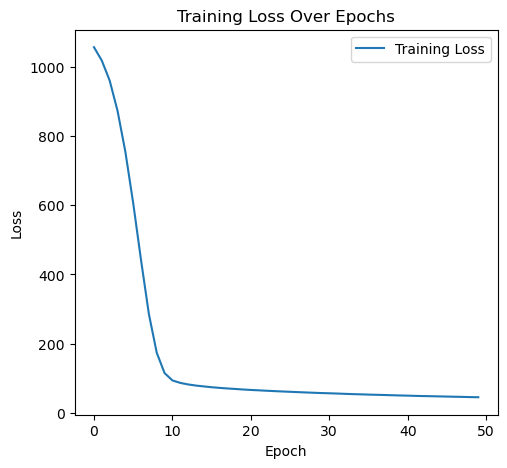

In [12]:
# loss 변화 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.show()